In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import os
import seaborn as sns

from plot import plot_cluster_values, plot_decision_regions
from regression import LinearRegressionGD

c:\Users\CEDS\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.set_printoptions(precision=10, suppress=True)

In [3]:
def estandarizar(ex):
    return (ex - ex.mean() / ex.std())

def normalizar(ex):
    return (ex - ex.min()) / (ex.max() - ex.min())

# Cargar Datos

In [4]:
#################
### CARGAR DATOS
#################

datos = pd.read_csv('datos.csv')
# aceites = pd.read_csv('aceites.csv', encoding="latin-1")

completos = datos.dropna()

# Todas las composiciones
t_comp = datos.iloc[:, 2:5].copy()
# Todos los espectros
t_esp = datos.iloc[:, 5:].copy()

# Todos los espectros normalizados
t_espe_norm = normalizar(datos.iloc[:, 5:].copy())

# Composiciones completas normalizadas
c_comp_norm = normalizar(completos.iloc[:, 2:5].copy())
# Espectros completos normalizados
c_espe_norm = t_espe_norm[t_espe_norm.index.isin(c_comp_norm.index)].copy()

# Espectros incompletos normalizados
i_esp_norm = normalizar(datos[datos['C/G'].isna()].iloc[:, 5:].copy())

In [5]:
#################################################
# CREAR MODELO DE REGRESION, ENTRENAR Y PREDECIR
#################################################

# Espectros completos normalizados
X = c_espe_norm.values
# Composiciones completas normalizadas
y = c_comp_norm

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(t_espe_norm)

cov_mat = np.cov(X_train_pca.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

class WrapperModelo():
    # Crear constructor
    def __init__(self, nombre, model):
        self.nombre = nombre
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def ejecutar(self):
        if os.path.exists(f'output/{self.nombre}') is False:
            os.makedirs(f'output/{self.nombre}')
        # Obtener una estimacion utilizando todos los espectros normalizados
        self.estimaciones = pd.DataFrame(columns=["est_C/G", "est_G/N", "est_P/G"], data=self.predict(t_espe_norm))
        self.estimaciones.insert(loc=0, column="WL", value=datos["WL"])
        
        #############################################
        ### REEMPLAZAR VALORES EN LA MATRIZ ORIGINAL
        #############################################
        self.combinado = datos.copy()
        self.indices_vacios = self.combinado[self.combinado["C/G"].isna()].index
        self.combinado['STATE'] = 'original'
        self.combinado.loc[self.combinado["C/G"].isna(), 'STATE'] = 'estimacion'
        self.combinado.loc[self.combinado["C/G"].isna(), 'C/G'] = self.estimaciones.values[:, 1][self.indices_vacios]
        self.combinado.loc[self.combinado["G/N"].isna(), 'G/N'] = self.estimaciones.values[:, 2][self.indices_vacios]
        self.combinado.loc[self.combinado["P/G"].isna(), 'P/G'] = self.estimaciones.values[:, 3][self.indices_vacios]
        self.combinado = self.combinado[["WL", "STATE", "C/G", "G/N", "P/G"]]
        print(self.combinado)

    def guardar(self):
        self.estimaciones.to_csv(f'output/{self.nombre}/estimaciones.csv', index=False)
        self.combinado.to_csv(f'output/{self.nombre}/combinado.csv', index=False)

    def graficar(self):
        #############
        ### GRAFICAR
        #############
        # Graficar X = G/N, Y = C/G, color = STATE
        plt.scatter(
            self.combinado[self.combinado["STATE"] == 'original']['G/N'],
            self.combinado[self.combinado["STATE"] == "original"]["P/G"],
            c='blue',
        )
        plt.scatter(
            self.combinado[self.combinado["STATE"] == 'estimacion']['G/N'],
            self.combinado[self.combinado["STATE"] == "estimacion"]["P/G"],
            c='red',
        )
        plt.xlabel('G/N')
        plt.ylabel('P/G')
        plt.show()

In [6]:
modelos = {
    "linear": LinearRegression(),
    # 'ridge': (),
    # "lasso": Lasso(alpha=0.1),
}


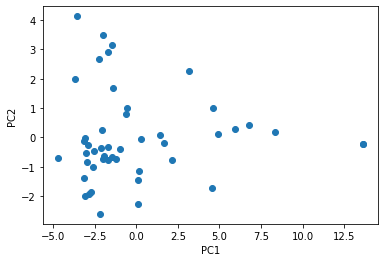

In [7]:
# Todos los espectros normalizados
# Xc = t_espe_norm.values
Xc = X_train_pca

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(Xc[:, 0], Xc[:, 1])
plt.show()

In [8]:
n_clusters=6
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'orange', 'purple', 'brown', 'black']
#KMeans
km = KMeans(n_clusters=n_clusters, random_state=0)
km.fit(Xc)
kmResult = km.predict(Xc)
labels = km.labels_

esp_clasificados = t_espe_norm.copy()
esp_clasificados = esp_clasificados.assign(TYPE=labels)

In [9]:
def graficar_modelo_clasificado(modelo):
    plt.suptitle("Estimación de las composiciones clasificadas")
    for color, type in zip(colors, range(n_clusters)):
        found = modelo.combinado[modelo.combinado["TYPE"] == type]
        plt.scatter(
            found['G/N'],
            found["P/G"],
            # c=color,
            label=f"Cluster {type}"
        )
    plt.legend()
    plt.xlabel('G/N')
    plt.ylabel('P/G')
    plt.show()

           WL       STATE       C/G       G/N       P/G
0   AGUACLARA    original       0.0     1.068    0.0398
1     AGUAL02    original       0.0    0.8207    0.6335
2       ARCHT    original    0.0001    1.1932    0.4353
3        ASUS  estimacion  0.203844  0.678742  0.623404
4      BALREP    original       0.0    1.0621    0.0297
5        BASE  estimacion -0.263791  0.520911  0.249146
6          BB  estimacion  0.056896  0.909917  0.414655
7       CAT01    original       0.0    0.7846     0.193
8       CAT02    original       0.0    0.8006    0.4708
9       CHANK  estimacion -0.405505  0.844392  0.258763
10        CHE  estimacion  0.146723  0.506857  0.203873
11        CHP  estimacion -0.098476  0.434653  0.606964
12         CI  estimacion  0.212348    0.8941  0.141853
13    CTRON01    original       0.0    0.8397    0.5696
14    CTRON02    original       0.0    0.8368    0.4346
15         GP  estimacion  0.217023  0.663104  0.102963
16      HLSJP  estimacion -0.151816  0.390326  0

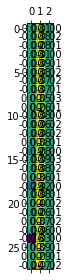

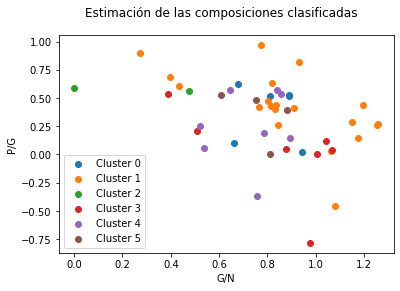

In [10]:
for m in modelos:
    modelo = WrapperModelo(m, modelos[m])
    # Entrenar unicamente utilizando los espectros normalizados (x) y composiciones normalizadas (y) completos
    modelo.fit(X, y.values)
    modelo.ejecutar()
    modelo.estimaciones.insert(loc=1, column="TYPE", value=kmResult)
    modelo.combinado.insert(loc=1, column="TYPE", value=kmResult)
    # modelo.estimaciones.assign(TYPE=kmResult)
    modelo.guardar()
    error = (modelo.combinado.values[c_comp_norm.index][:, 3:6] - modelo.estimaciones.values[c_comp_norm.index][:, 2:5]).astype(float)
    print(error)

    fig, ax = plt.subplots()
    ax.matshow(error)
    for (i, j), z in np.ndenumerate(error):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()
    # plt.plot(range(1,modelo.model.n_inter+1), modelo.model.cost_)
    # plt.show()
    # modelo.graficar()
    graficar_modelo_clasificado(modelo)

In [11]:
esp_clasificados = esp_clasificados.assign(ACEITE=datos["WL"])
esp_clasificados.insert(0, "ACEITE", esp_clasificados.pop('ACEITE'))
esp_clasificados.insert(1, "TYPE", esp_clasificados.pop('TYPE'))

cols = [float(x) for x in t_espe_norm.columns]

C:\Users\CEDS\AppData\Local\Temp/ipykernel_40020/4139764099.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  zipped = np.asarray([x for x in list(zip(kmResult, Xc))])


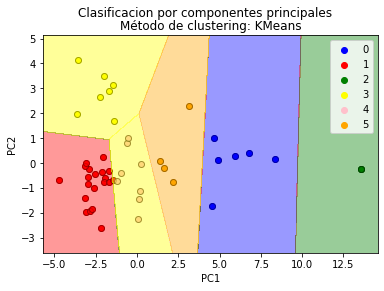

In [12]:
plt.suptitle('Clasificacion por componentes principales')
plt.title('Método de clustering: KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
zipped = np.asarray([x for x in list(zip(kmResult, Xc))])
for label in np.sort(np.unique(labels)):
    coords = np.array([i[1] for i in zipped if i[0] == label])
    plt.scatter(coords[:, 0], coords[:, 1], c=colors[label], label=label)

for i in range(len(km.cluster_centers_)):
    centroid = km.cluster_centers_[i]

plt.legend(loc='upper right')
plot_decision_regions(Xc, labels, classifier=km)

plt.show()

In [13]:
figsize_orig = plt.rcParams['figure.figsize']

figsize_orig

[6.0, 4.0]

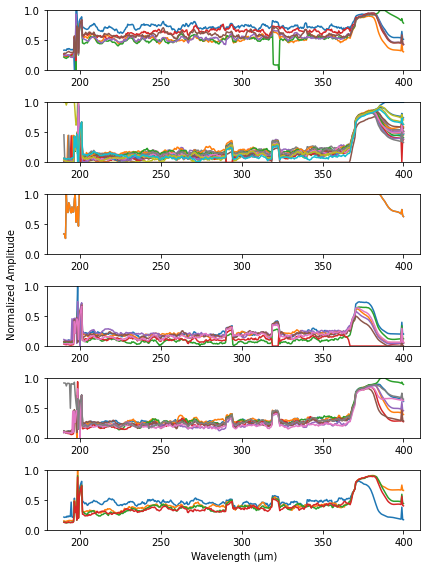

In [14]:
plt.rcParams['figure.figsize'] = [3*2, 4*2]

fig, axs = plt.subplots(n_clusters)

esp_clasificados.to_csv("clasificados.csv")

for color, type in zip(colors, range(n_clusters)):
    # rows = esp_clasificados[esp_clasificados["TYPE"] == type].loc[:, esp_clasificados.columns != 'TYPE']
    rows = esp_clasificados[esp_clasificados["TYPE"] == type].iloc[:, 2:]
    # axs[type].set_title(f'Cluster {type} ({len(rows)} essential oils)')
    # axs[type].set(xlabel='Wavelength', ylabel='Normalized\nAmplitude')
    # Set y lim
    axs[type].set_ylim(0, 1)
    for index, row in rows.iterrows():
        axs[type].plot(
            cols,
            row,
            label=datos['WL'][index],
            # color=color
        )
fig.text(0.03, 0.5, 'Normalized Amplitude', ha='center', va='center', rotation='vertical')
plt.xlabel(u"Wavelength (\u03bcm)")
plt.ylabel(" ", loc='top')
plt.subplots_adjust(
    top=0.96,
    bottom=0.06,
    left=0.125,
    right=0.9,
    hspace=0.89,
    wspace=0.2
)
plt.tight_layout()
plt.savefig('prueba.png', dpi=300)
plt.show()

In [15]:
dummies = pd.get_dummies(datos.iloc[:, 1:])
new_cols = [*dummies.columns[:3], *dummies.columns[-6:], *dummies.columns[3:-6]]

df = dummies[new_cols]


In [16]:
def nice_number(i):
    return '%.1f' % i if i - int(i) != 0 else '%d' % i

In [17]:
nice_number(100.5)

'100.5'

In [18]:
cols = [nice_number(x) for x in np.arange(190, 400.5, 0.5)]
cols.reverse()

cols

['400',
 '399.5',
 '399',
 '398.5',
 '398',
 '397.5',
 '397',
 '396.5',
 '396',
 '395.5',
 '395',
 '394.5',
 '394',
 '393.5',
 '393',
 '392.5',
 '392',
 '391.5',
 '391',
 '390.5',
 '390',
 '389.5',
 '389',
 '388.5',
 '388',
 '387.5',
 '387',
 '386.5',
 '386',
 '385.5',
 '385',
 '384.5',
 '384',
 '383.5',
 '383',
 '382.5',
 '382',
 '381.5',
 '381',
 '380.5',
 '380',
 '379.5',
 '379',
 '378.5',
 '378',
 '377.5',
 '377',
 '376.5',
 '376',
 '375.5',
 '375',
 '374.5',
 '374',
 '373.5',
 '373',
 '372.5',
 '372',
 '371.5',
 '371',
 '370.5',
 '370',
 '369.5',
 '369',
 '368.5',
 '368',
 '367.5',
 '367',
 '366.5',
 '366',
 '365.5',
 '365',
 '364.5',
 '364',
 '363.5',
 '363',
 '362.5',
 '362',
 '361.5',
 '361',
 '360.5',
 '360',
 '359.5',
 '359',
 '358.5',
 '358',
 '357.5',
 '357',
 '356.5',
 '356',
 '355.5',
 '355',
 '354.5',
 '354',
 '353.5',
 '353',
 '352.5',
 '352',
 '351.5',
 '351',
 '350.5',
 '350',
 '349.5',
 '349',
 '348.5',
 '348',
 '347.5',
 '347',
 '346.5',
 '346',
 '345.5',
 '345',
 '

In [19]:
df

,C/G,G/N,P/G,TYPE_a,TYPE_b,TYPE_c,TYPE_d,TYPE_e,TYPE_f,400,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
0,0.0000,1.0680,0.0398,0,0,1,0,0,0,0.038911,...,-0.031470,-0.032718,-0.031738,-0.031211,-0.033137,-0.034025,-0.035131,-0.038121,-0.038988,-0.039591
1,0.0000,0.8207,0.6335,0,0,0,1,0,0,0.091295,...,-0.038201,-0.038967,-0.038387,-0.038184,-0.039430,-0.039324,-0.040177,-0.042767,-0.042756,-0.043169
2,0.0001,1.1932,0.4353,0,1,0,0,0,0,0.055657,...,-0.035908,-0.036677,-0.036339,-0.036238,-0.003810,-0.038744,-0.039666,-0.041618,-0.041893,-0.042257
3,NaN,NaN,NaN,1,0,0,0,0,0,0.059881,...,-0.011623,-0.011494,-0.010422,-0.010354,-0.011640,-0.011216,-0.012399,-0.014607,-0.014871,-0.015332
4,0.0000,1.0621,0.0297,1,0,0,0,0,0,0.057428,...,-0.038808,-0.039660,-0.039182,-0.038191,-0.040188,-0.040158,-0.041435,-0.043226,-0.043769,-0.044302
5,NaN,NaN,NaN,0,0,0,1,0,0,0.065730,...,-0.030065,-0.030913,-0.030427,-0.030065,-0.031735,-0.032500,-0.034374,-0.035994,-0.036041,-0.035945
6,NaN,NaN,NaN,1,0,0,0,0,0,0.059393,...,-0.038590,-0.039290,-0.039085,-0.039217,-0.040947,-0.041169,-0.042409,-0.045475,-0.046121,-0.046857
7,0.0000,0.7846,0.1930,1,0,0,0,0,0,0.051442,...,-0.031851,-0.032031,-0.031328,-0.031234,-0.032842,-0.032777,-0.033630,-0.035894,-0.036379,-0.036836
8,0.0000,0.8006,0.4708,1,0,0,0,0,0,0.056960,...,-0.038324,-0.039388,-0.039289,-0.038897,-0.040833,-0.040995,-0.041835,-0.044519,-0.045283,-0.045702
9,NaN,NaN,NaN,1,0,0,0,0,0,0.059933,...,-0.037781,-0.038929,-0.038568,-0.038826,-0.040436,-0.041401,-0.042255,-0.044495,-0.044752,-0.044374


In [33]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [106]:
# subset = df.iloc[:, -20:-14]
subset = df.iloc[:, -24:]
nums_col = subset.columns
comp_col = ['C/G', 'G/N', 'P/G']


subset = df[[*comp_col, *nums_col]].dropna()
col = subset.columns
subset.head()

,C/G,G/N,P/G,201.5,201,200.5,200,199.5,199,198.5,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
0,0.0000,1.0680,0.0398,0.089650,0.076685,0.062667,0.047714,0.031108,0.015359,0.064315,...,-0.031470,-0.032718,-0.031738,-0.031211,-0.033137,-0.034025,-0.035131,-0.038121,-0.038988,-0.039591
1,0.0000,0.8207,0.6335,0.083970,0.071425,0.057544,0.042338,0.026215,0.010279,-0.041828,...,-0.038201,-0.038967,-0.038387,-0.038184,-0.039430,-0.039324,-0.040177,-0.042767,-0.042756,-0.043169
2,0.0001,1.1932,0.4353,0.085259,0.007220,0.058225,0.042901,0.027648,0.011947,-0.025398,...,-0.035908,-0.036677,-0.036339,-0.036238,-0.003810,-0.038744,-0.039666,-0.041618,-0.041893,-0.042257
4,0.0000,1.0621,0.0297,0.081937,0.068976,0.054000,0.038850,0.022989,0.072203,-0.073889,...,-0.038808,-0.039660,-0.039182,-0.038191,-0.040188,-0.040158,-0.041435,-0.043226,-0.043769,-0.044302
7,0.0000,0.7846,0.1930,0.088722,0.076099,0.061851,0.046387,0.030976,0.015637,0.015086,...,-0.031851,-0.032031,-0.031328,-0.031234,-0.032842,-0.032777,-0.033630,-0.035894,-0.036379,-0.036836


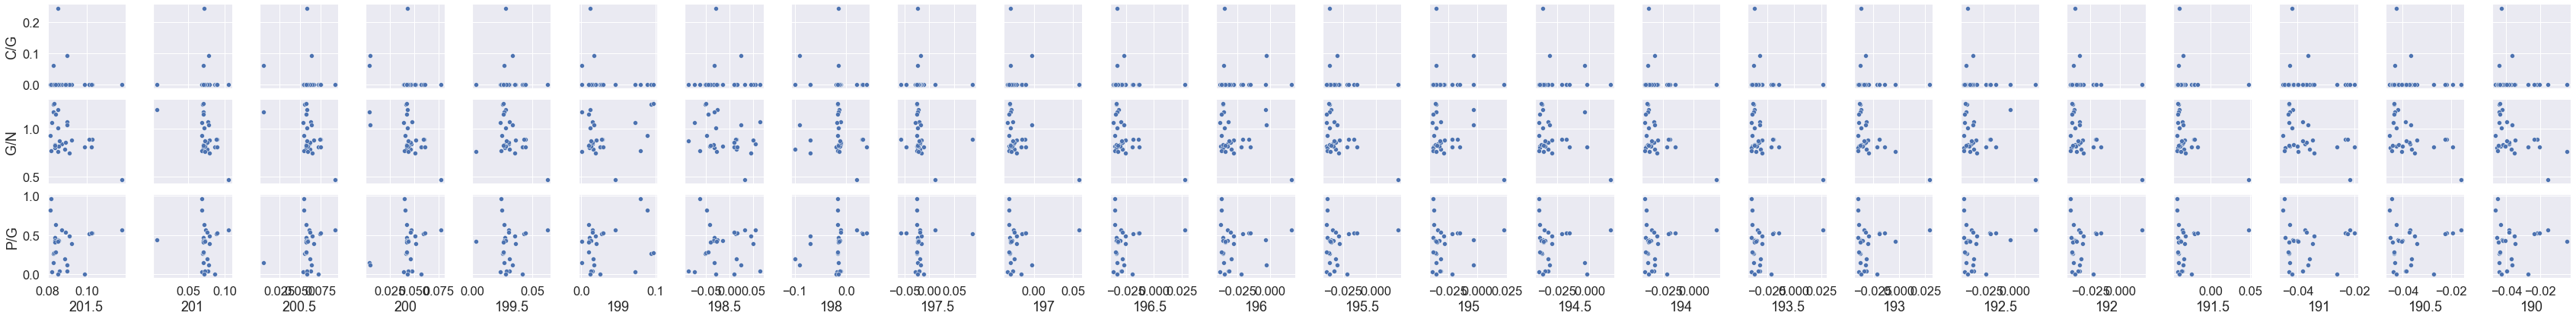

In [113]:
sns.pairplot(subset, height=2.0, y_vars=comp_col, x_vars=nums_col)
plt.savefig("pairplot_ngp.png")
plt.show()

In [108]:
subset.corr().iloc[:3,3:]

,201.5,201,200.5,200,199.5,199,198.5,198,197.5,197,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
C/G,-0.111244,-0.014110,-0.201048,-0.347929,-0.057289,-0.182837,-0.036735,-0.138809,-0.040870,-0.015574,...,-0.013694,-0.108306,-0.107700,-0.122126,-0.131707,-0.107701,-0.094855,-0.131128,-0.140699,-0.140917
G/N,-0.519555,-0.524836,-0.531995,-0.547159,-0.379158,0.255675,-0.321146,-0.078688,-0.169148,-0.510789,...,-0.358276,-0.551359,-0.556767,-0.591254,-0.359096,-0.563042,-0.561497,-0.459665,-0.493034,-0.501952
P/G,0.081010,0.008797,0.190781,0.273018,0.066817,0.229077,0.021210,0.267107,0.036421,0.094323,...,-0.080358,0.111459,0.114859,0.119373,0.128844,0.106730,0.128476,0.039304,0.083487,0.085227


In [82]:
plt.rcParams['figure.figsize']

[6.0, 8.0]

In [110]:
plt.rcParams['figure.figsize'] = [
    12.0*3,
    8.0*1
]

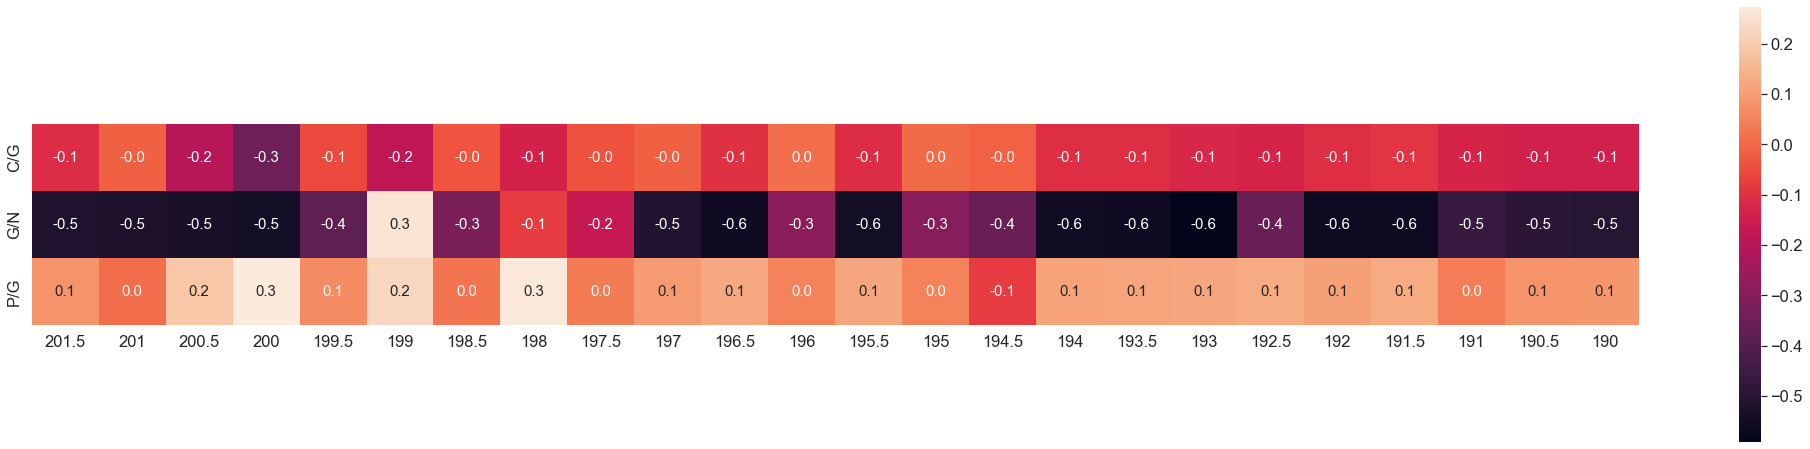

In [111]:
# cm = np.corrcoef(subset[nums_col].values.T, subset[comp_col].values.T)
# sns.set(font_scale=1.5)
hm = sns.heatmap(subset.corr().iloc[:3,3:],
    cbar=True,
    annot=True,
    square=True,
    fmt='.1f',
    annot_kws={'size': 15},
    yticklabels=['C/G', 'G/N', 'P/G'],
    xticklabels=nums_col
)
plt.savefig("heatmap.png")
plt.show()